# Default of Credit Card Clients Project - Group4

## I. Environment setup

In [40]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
import random
import plotly.express as px
import plotly.figure_factory as ff

## II. Data import and preparation

In [2]:
df = pd.read_csv("data/default_of_credit_card_clients.csv", skiprows=1)

In [20]:
random.seed()

# rename column to get rid of spaces 

df.rename(columns = {"default payment next month":"default_payment"}, inplace = True)


# split into test and training set 

train_df, test_df = train_test_split(df, test_size=0.2)

X_train, y_train = (train_df.drop(columns=["default_payment"]),
                   train_df["default_payment"])

X_test, y_test = (test_df.drop(columns=["default_payment"]),
                  test_df["default_payment"])


The dataset was split into a 80% training and 20% testing set. The model will be built using only the training data. This gives the abilithy to compute a final performance metric for our model by evaluating it on the testing data. train_test_split() function shuffles the data to ensure the data ending up in the training and test sets is randomized. 

## III. Exploratory Data Analysis

### III-1. Dataset overview

First we have a look at our dataset:

In [84]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Then we check the number of rows and columns:

In [19]:
df.shape

(30000, 25)

Hence, there are 25 variables and 30,000 entries in this dataset.

### III-2. Check missing values

Now let's check if the dataset has null/missing values that may affect further analysis:

In [82]:
df.isnull().sum()

ID                 0
LIMIT_BAL          0
SEX                0
EDUCATION          0
MARRIAGE           0
AGE                0
PAY_0              0
PAY_2              0
PAY_3              0
PAY_4              0
PAY_5              0
PAY_6              0
BILL_AMT1          0
BILL_AMT2          0
BILL_AMT3          0
BILL_AMT4          0
BILL_AMT5          0
BILL_AMT6          0
PAY_AMT1           0
PAY_AMT2           0
PAY_AMT3           0
PAY_AMT4           0
PAY_AMT5           0
PAY_AMT6           0
default_payment    0
dtype: int64

Great! The dataset is super clean, and no missing value is found.

### III-3. Statistics information

This part we have a look at some basic statistics of the training set:

In [81]:
train_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,14988.918458,166841.083333,1.603417,1.852667,1.552333,35.484000,-0.010458,-0.126625,-0.161917,-0.217208,...,43411.321625,40434.919875,38908.758792,5606.706542,5.858557e+03,5208.646542,4859.642292,4761.178625,5258.779292,0.221708
std,8657.928255,130007.840778,0.489198,0.789242,0.522356,9.223722,1.124456,1.196516,1.198023,1.169403,...,64733.530030,61331.856502,59888.231840,16316.932412,2.071881e+04,17799.123205,16105.742647,15014.682912,17931.687397,0.415405
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7496.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2400.000000,1831.750000,1262.000000,1000.000000,8.500000e+02,396.000000,300.000000,257.000000,144.750000,0.000000
50%,14984.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19068.000000,18129.000000,17056.500000,2100.000000,2.008000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,22478.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54179.750000,49891.750000,48885.000000,5004.000000,5.000000e+03,4552.000000,4015.250000,4069.000000,4006.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


We can see the following information:
1. The average amount of given credit in NT dollars is 166841.083333;
2. The average age of all clients is 35.484000, etc.

To better understand the correlation between variables, we would like to compute and visualize the correlations:

<AxesSubplot:>

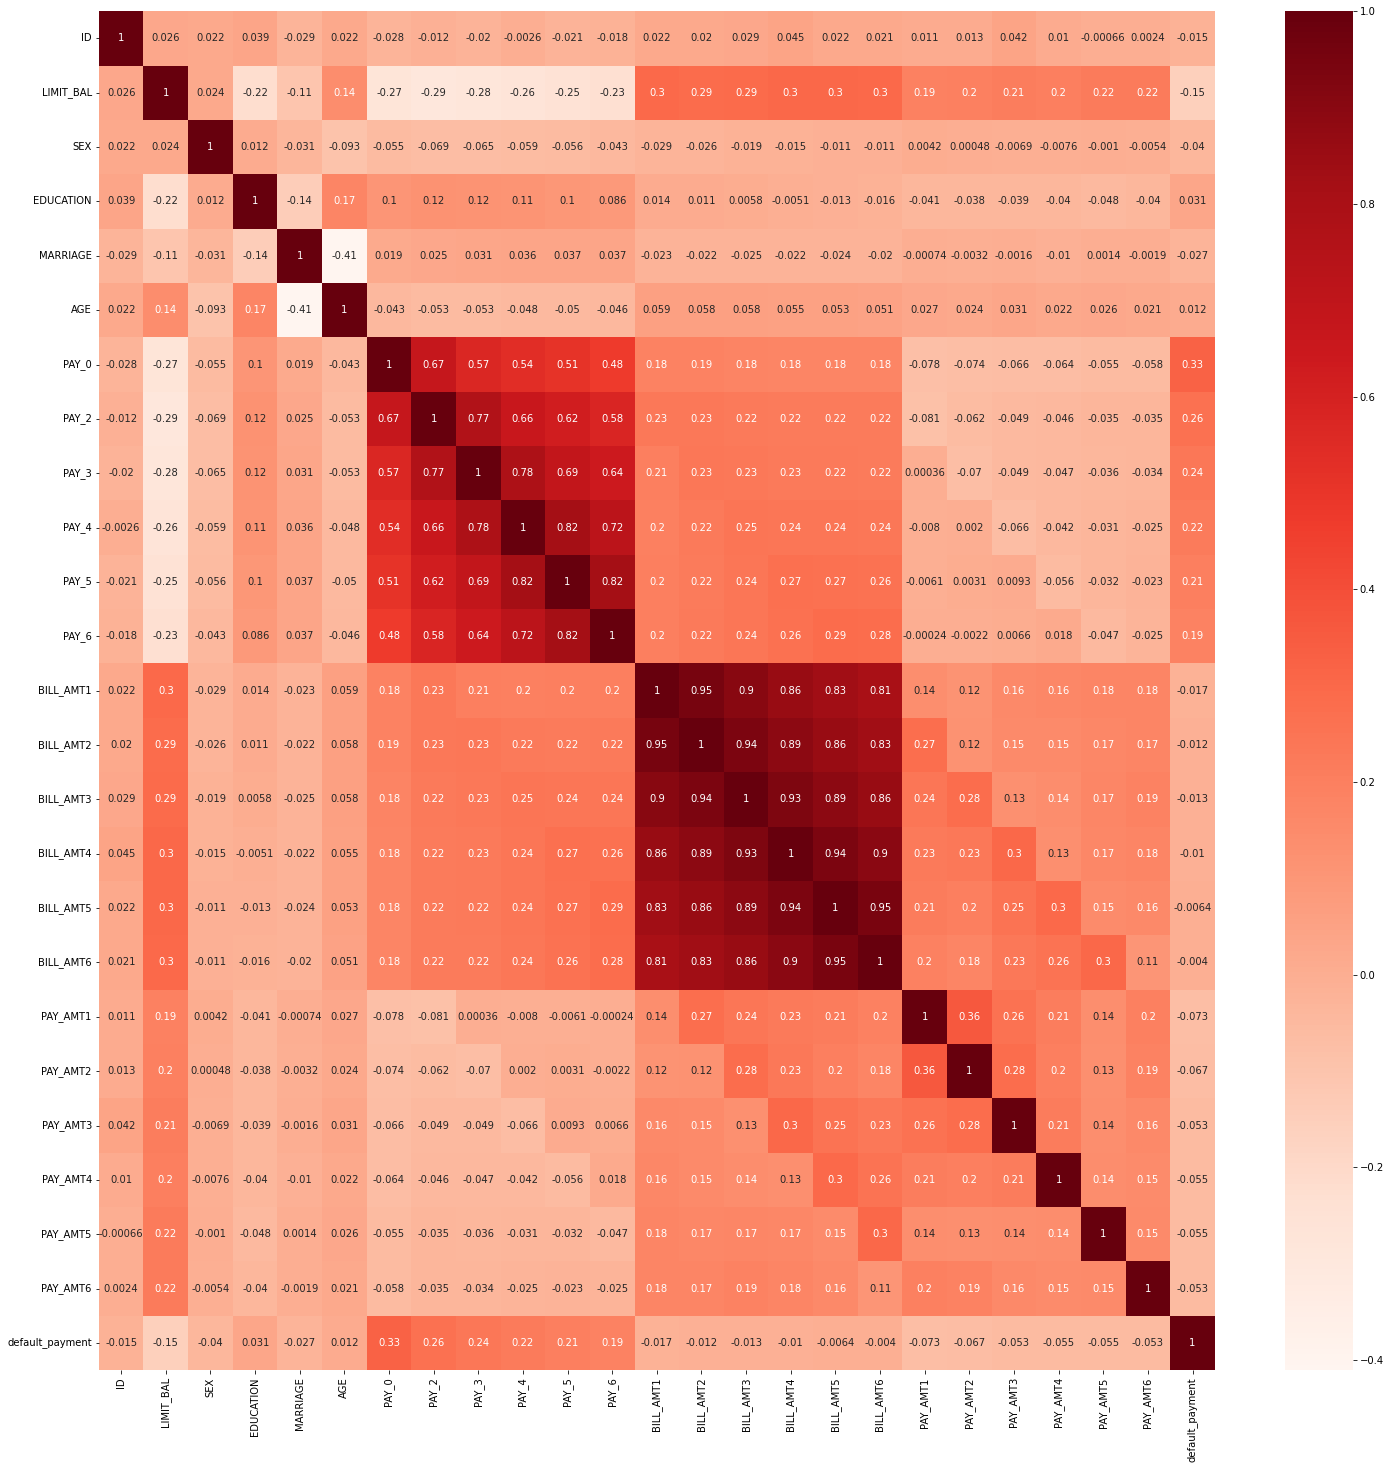

In [80]:
plt.figure(figsize=(25,25))
sns.heatmap(train_df.corr(),cbar=True,annot=True,cmap='Reds')

The heatmap shows some positive/negative correlations:

Positive correlations:
1. Default payment - PAY_0 to PAY_6 (Repayment status from April to September, 2005);
2. Limit balance - BILL_AMT1 to BILL_AMT6 (Amount of bill statement from April to September, 2005), etc.

Negative correlations:
1. Limit balance - PAY_0 to PAY_6 (Repayment status from April to September, 2005), etc.

Specifically, PAY_0 has the highest correlation with default_payment. This will give us a signal that PAY_0 plays an important role for predicting default_payment.


### III-4. Exploring variables

#### 1. LIMIT_BAL

First, we look at the amount of given credit (in NT dollars). Credit card limits are likely an indictor of how wealthy someone is since banks tend to give higher limits to clients that have more money with them. Thus, this may be an important feature when predicting if someone is able to pay the bill on time. 

/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Density'>

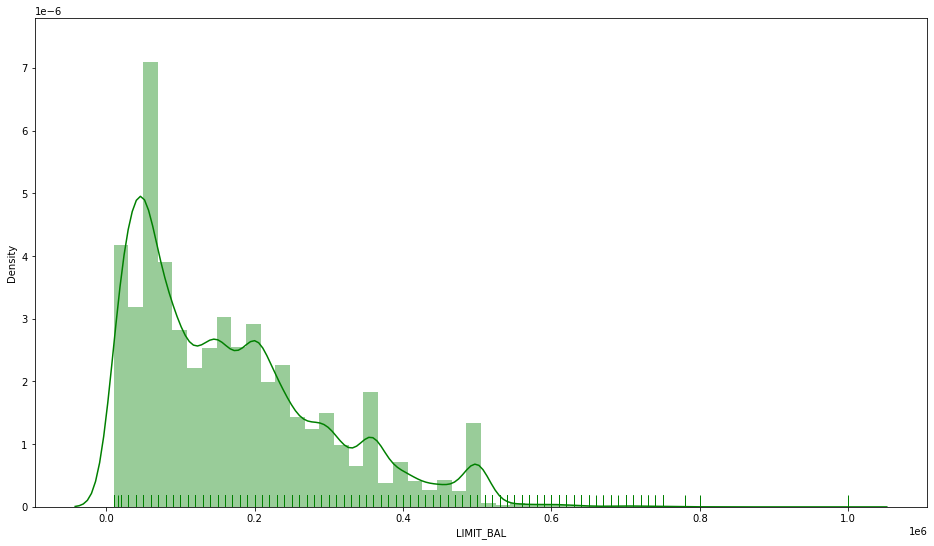

In [79]:
plt.figure(figsize = (16,9))
sns.distplot(train_df['LIMIT_BAL'],kde=True,bins=50, rug = True, color="green")

### Class Imbalance

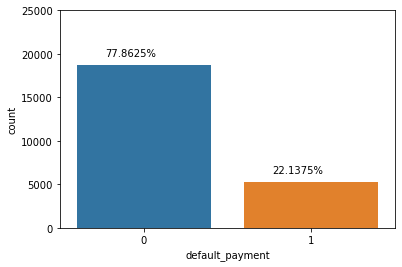

In [8]:
plt.figure(figsize=(6,4))

default_plot = sns.countplot(x = "default_payment",data = train_df)
plt.ylim(0,25000)
total = float(len(train_df))
for p in default_plot.patches:
    default_plot.annotate((str(100* p.get_height()/total) + "%"), (p.get_x()+0.32, p.get_height()+1000), ha="center")


plt.show()



The above plot shows the percentage of rows with default payment = 0 versus default payment = 1. Cleary there is class imbalance in this dataset. Because of this, we will use the area under the Receiver Operating Characterisitc curve (ROC AUC) as our primary metric to evaluate our model instead of accuracy, which tends to be missleading in cases of class imbalance. ROC AUC evalauates how good the model is as distinguishing between classes, and gives a more accurate sense of how well our model generalizes when dealing with class imbalance.

### Preprossesing 

We apply scaling to numeric features to ensure the model built will be robust and not sensitive to the scale of each individual feature. To do this, we use the StandardScaler() function to set the sample mean to 0 and standard deviation to 1.

To handle categorical values, we will apply one-hot-encoding. This creates binary dummy variables for each category. 

There are no null values in the dataset so there is no need to handle missing values. 

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 4680 to 3970
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               24000 non-null  int64
 1   LIMIT_BAL        24000 non-null  int64
 2   SEX              24000 non-null  int64
 3   EDUCATION        24000 non-null  int64
 4   MARRIAGE         24000 non-null  int64
 5   AGE              24000 non-null  int64
 6   PAY_0            24000 non-null  int64
 7   PAY_2            24000 non-null  int64
 8   PAY_3            24000 non-null  int64
 9   PAY_4            24000 non-null  int64
 10  PAY_5            24000 non-null  int64
 11  PAY_6            24000 non-null  int64
 12  BILL_AMT1        24000 non-null  int64
 13  BILL_AMT2        24000 non-null  int64
 14  BILL_AMT3        24000 non-null  int64
 15  BILL_AMT4        24000 non-null  int64
 16  BILL_AMT5        24000 non-null  int64
 17  BILL_AMT6        24000 non-null  int64
 18  PAY_

In [12]:
numeric_feats = [     # apply scaling
    "LIMIT_BAL",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4", 
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
    "AGE",
]

categorical_feats = [  # apply one-hot encoding
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "EDUCATION",
    "SEX",
    "MARRIAGE",
]

Next, we apply scaling and one-hot-encoding through using a column transformer, which applies the transformations to each column specified. 

In [14]:
ct = make_column_transformer(
    (StandardScaler(), numeric_feats,),
    (OneHotEncoder(handle_unknown="ignore"), categorical_feats,),

)

### Baseline Model

Firstly, we will try a baseline model to act as a comparison measure for the final model built. Using a pipeline to do this ensures that the model is built using just the training data, and that the testing data has no influence on the model. 5-fold Cross validation is used to give a more robust measure of performance error. K-fold Cross-validation spilts the training data into k folds, and each time one fold is the validation set. Each fold fits the model on the training portion and uses one fold as a validation set to calculate a performance metric, which can be averaged to get a overall score of how well the model does. This ensures that outliers don't negatively influence the performance metric. 

In [16]:
from sklearn.model_selection import cross_val_predict

dummy = DummyClassifier()

pipe = make_pipeline(ct, dummy)

scores = cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5, scoring="roc_auc")
scores = pd.DataFrame(scores)
scores

,fit_time,score_time,test_score,train_score
0,0.080761,0.014796,0.5,0.5
1,0.045071,0.014051,0.5,0.5
2,0.050334,0.014921,0.5,0.5
3,0.046529,0.014421,0.5,0.5
4,0.044651,0.014352,0.5,0.5


### Logistic Regression

Next, a logistic regression model is fitted to the training data. Logistic regression uses the training data to learn coefficients, which then can be used to calculate prediction probabilities of the each class using the sigmoid function. This allows us to calculate the likelihood of a person defaulting on their credit card. The hyperparameter C is used to control the fundatamental tradeoff of bias and variance, to reduce the likeliness of the model overfitting or underfitting. 

In [22]:
random.seed()

train_scores = []
cv_scores = []

C = 10.0 ** np.arange(-1.5, 2, 0.5)

for c in C:
    
    pipe_lr = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, C=c),
    )
    
    results = cross_validate(pipe_lr, X_train, y_train, return_train_score=True, scoring = "roc_auc")
    
    train_scores.append(results["train_score"].mean())
    cv_scores.append(results["test_score"].mean())
    

scores = pd.DataFrame({"C": C, "Train Scores": train_scores, "CV Scores": cv_scores })

scores


,C,Train Scores,CV Scores
0,0.031623,0.772838,0.769484
1,0.100000,0.773099,0.769361
2,0.316228,0.773205,0.769095
3,1.000000,0.773281,0.768788
4,3.162278,0.773344,0.768452
5,10.000000,0.773407,0.768063
6,31.622777,0.773459,0.767816


In [25]:
best_C = scores.loc[scores["CV Scores"].idxmax(), "C"]
print("best C value: " + str(best_C))

best C value: 0.03162277660168379
